In [42]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import optuna
import pandas as pd
import numpy as np
import xgboost as xgb
import sklearn.metrics as metrics
import sklearn.preprocessing as prep
import sklearn.model_selection as ms
from functools import partial
from sklearn.utils import resample

In [63]:
# 데이터 불러오기
train_data = pd.read_csv("~/project/MIMIC-III/Baseline/overlap/OI/overlap_OI(50%)_train.csv")
test_data = pd.read_csv("~/project/MIMIC-III/Baseline/overlap/OI/overlap_OI(50%)_test.csv")

train_data.rename(columns={'HOSPITAL_EXPIRE_FLAG': 'y'}, inplace=True)
test_data.rename(columns={'HOSPITAL_EXPIRE_FLAG': 'y'}, inplace=True)

train_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "ETHNICITY"], axis=1, inplace=True)
test_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "ETHNICITY"], axis=1, inplace=True)

train_data = pd.get_dummies(train_data, columns=["GENDER"])
test_data = pd.get_dummies(test_data, columns=["GENDER"])

# train_data와 test_data의 칼럼을 맞추기 위해 차집합을 계산
missing_columns_in_test = set(train_data.columns) - set(test_data.columns)
missing_columns_in_train = set(test_data.columns) - set(train_data.columns)

# test_data에 train_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_test:
    test_data[col] = 0

# train_data에 test_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_train:
    train_data[col] = 0
    
####################################################################
# Down Sampling
# train 데이터의 레이블 비율 확인
train_labels = train_data['y']
label_counts = train_labels.value_counts()

# train 데이터의 레이블 비율이 1:1이 되도록 분할
class_0_data = train_data[train_data['y'] == 0]
class_1_data = train_data[train_data['y'] == 1]

# 레이블이 0인 데이터 중에서 샘플 개수가 적은 만큼만 선택
num_samples = min(label_counts[0], label_counts[1])
class_0_data = class_0_data.sample(num_samples, random_state=42)

# 레이블이 1인 데이터 중에서 샘플 개수가 적은 만큼만 선택
class_1_data = class_1_data.sample(num_samples, random_state=42)

# 선택한 데이터를 결합하여 최종 train 데이터 생성
train_data = pd.concat([class_0_data, class_1_data])
####################################################################


# Features와 Target 설정
X_train = train_data.drop('y', axis=1)
y_train = train_data['y']
X_test = test_data.drop('y', axis=1)

print("train shape\n",X_train.shape,"\n")
print("train shape\n",X_test.shape,"\n")

target = "y"
features = [f for f in train_data.columns if f not in [target]]

print("train value\n",train_data['y'].value_counts(),"\n")
print("test value\n",test_data['y'].value_counts())

train shape
 (2662, 130) 

train shape
 (1918, 130) 

train value
 0    1331
1    1331
Name: y, dtype: int64 

test value
 0    1304
1     614
Name: y, dtype: int64


In [64]:
# test_data와 train_data의 칼럼 차이 확인
column_difference = set(X_train.columns) - set(X_test.columns)
print("칼럼 차이:", column_difference)

칼럼 차이: set()


In [65]:
model=xgb.XGBClassifier(seed=1,
            tree_method="gpu_hist",
            gpu_id=0,
            predictor="gpu_predictor",
            n_estimators=100)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor='gpu_predictor', random_state=None, ...)

In [66]:
y_pred2 = model.predict(X_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(train_data['y'], y_pred2)
print("Train Accuracy:", accuracy) 
accuracy = accuracy_score(test_data['y'], y_pred)
print("Test Accuracy:", accuracy)

Train Accuracy: 1.0
Test Accuracy: 0.6360792492179353


In [67]:
class CrossValidation:
    def __init__(self, df, shuffle,random_state=None):
        self.df = df
        self.random_state = random_state
        self.shuffle = shuffle
        if shuffle is True:
            self.df = df.sample(frac=1,
                random_state=self.random_state).reset_index(drop=True)

    def hold_out_split(self,percent,stratify=None):
        if stratify is not None:
            y = self.df[stratify]
            train,val = ms.train_test_split(self.df, test_size=percent/100,
                stratify=y, random_state=self.random_state)
            return train,val
        size = len(self.df) - int(len(self.df)*(percent/100))
        train = self.df.iloc[:size,:]
        val = self.df.iloc[size:,:]
        return train,val

    def kfold_split(self, splits, stratify=None):
        if stratify is not None:
            kf = ms.StratifiedKFold(n_splits=splits,
                shuffle=self.shuffle,
                random_state=self.random_state)
            y = self.df[stratify]
            for train, val in kf.split(X=self.df,y=y):
                t = self.df.iloc[train,:]
                v = self.df.iloc[val, :]
                yield t,v
        else:
            kf = ms.KFold(n_splits=splits, shuffle=self.shuffle,
                random_state=self.random_state)
            for train, val in kf.split(X=self.df):
                t = self.df.iloc[train,:]
                v = self.df.iloc[val, :]
                yield t,v
seed = 42
folds = 5
cv = CrossValidation(train_data,
                     shuffle=True,
                     random_state=seed
                    )

In [68]:
def tuning_params(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1100, step=100)
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-8, 100.0, log=True)
    reg_alpha = trial.suggest_float("reg_alpha", 1e-8, 100.0, log=True)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    max_depth = trial.suggest_int("max_depth", 2, 5)
    
    for train_, val_ in cv.kfold_split(folds):
        trainX = train_[features]
        trainY = train_[target]
        valX = val_[features]
        valY = val_[target]
        
        model = xgb.XGBClassifier(
            seed=1,
            tree_method="gpu_hist",
            gpu_id=0,
            predictor="gpu_predictor",
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            reg_lambda=reg_lambda,
            reg_alpha=reg_alpha,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            max_depth=max_depth,
            use_label_encoder=False,
            early_stopping_rounds=300, 
                 
        )
        
        model.fit(trainX, trainY, 
                   eval_set=[(valX, valY)],
                  verbose=False
                 )
    
        predY = model.predict(valX)
        val_auc = metrics.roc_auc_score(valY, predY)
        return val_auc

In [69]:
study = optuna.create_study(direction="maximize")
study.optimize(tuning_params, n_trials=30, gc_after_trial=True)

[I 2023-08-22 16:21:22,873] A new study created in memory with name: no-name-3450e28e-6525-4c87-a225-644329a52c3e
/home/watercar99/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2023-08-22 16:21:29,208] Trial 0 finished with value: 0.6918056613891006 and parameters: {'n_estimators': 900, 'learning_rate': 0.012006308896142426, 'reg_lambda': 0.00031524274070690025, 'reg_alpha': 3.618184014592542e-06, 'subsample': 0.769093479386566, 'colsample_bytree': 0.6083734747921945, 'max_depth': 5}. Best is trial 0 with value: 0.6918056613891006.
/home/watercar99/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2023-08-22 16:21:31,857] Trial 1 finished with value: 0.6622781023339824 and parameters: {'n_estimators': 1000, 'learning_rat

In [70]:
print(study.best_params)

{'n_estimators': 1000, 'learning_rate': 0.018962253337109262, 'reg_lambda': 0.00039971114563659786, 'reg_alpha': 5.103673267603467e-07, 'subsample': 0.7085712755279477, 'colsample_bytree': 0.4146494994116916, 'max_depth': 4}


In [71]:
for train_, val_ in cv.kfold_split(folds):
        trainX = train_[features]
        trainY = train_[target]
        valX = val_[features]
        valY = val_[target]
        
        model = xgb.XGBClassifier(
            seed=1,
            tree_method="gpu_hist",
            gpu_id=0,
            predictor="gpu_predictor",
            n_estimators=study.best_params['n_estimators'],
            learning_rate=study.best_params['learning_rate'],
            reg_lambda=study.best_params['reg_lambda'],
            reg_alpha=study.best_params['reg_alpha'],
            subsample=study.best_params['subsample'],
            colsample_bytree=study.best_params['colsample_bytree'],
            max_depth=study.best_params['max_depth'],
            use_label_encoder=False,
        )
        model.fit(trainX,trainY,
                 early_stopping_rounds=300, 
                          eval_set=[(valX, valY)], verbose=False)

/home/watercar99/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/watercar99/.local/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/watercar99/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/watercar99/.local/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/watercar99/.local/lib/python3.9/site-packages/xgboost/skle

Train Accuracy: 0.8794139744552968
Test Accuracy: 0.6564129301355579


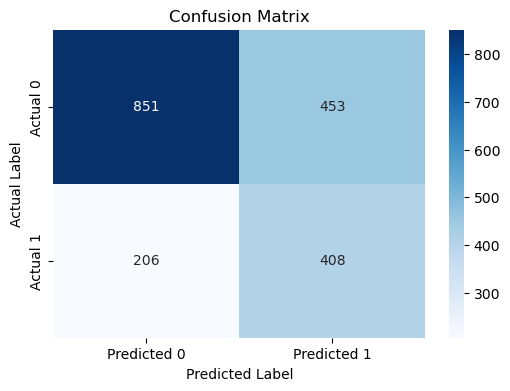

              precision    recall  f1-score   support

           0       0.81      0.65      0.72      1304
           1       0.47      0.66      0.55       614

    accuracy                           0.66      1918
   macro avg       0.64      0.66      0.64      1918
weighted avg       0.70      0.66      0.67      1918



In [72]:
y_pred2 = model.predict(X_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(train_data['y'], y_pred2)
print("Train Accuracy:", accuracy)
accuracy = accuracy_score(test_data['y'], y_pred)
print("Test Accuracy:", accuracy)
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
cm = confusion_matrix(test_data['y'], y_pred)
import matplotlib.pyplot as plt
# Confusion matrix를 pandas DataFrame으로 변환합니다
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

# Confusion matrix를 시각화합니다
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

from sklearn.metrics import classification_report
print(classification_report(test_data['y'], y_pred))

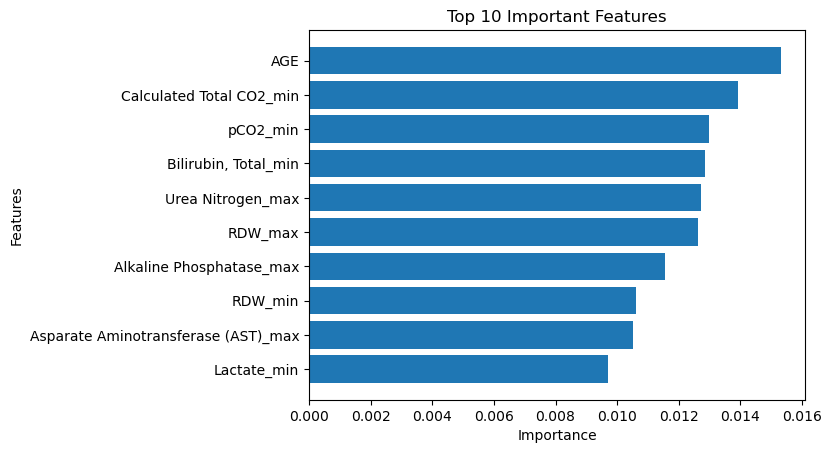

In [73]:
feature_importance = model.feature_importances_

# Get feature names
feature_names = X_train.columns

# Create a dictionary to store feature importance values and names
feature_importance_dict = {feature: importance for feature, importance in zip(feature_names, feature_importance)}

# Sort the feature importance dictionary by importance values in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Get the top 10 important features
top_10_features = sorted_feature_importance[:10]

# Extract feature names and importance values from the top 10 features
top_10_feature_names = [feature[0] for feature in top_10_features]
top_10_feature_importance = [feature[1] for feature in top_10_features]

# Invert the lists to reverse the order
top_10_feature_names.reverse()
top_10_feature_importance.reverse()

# Create a bar plot for the top 10 important features
plt.barh(top_10_feature_names, top_10_feature_importance)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 10 Important Features')
plt.show()